In [1]:
import pandas as pd
import numpy as np
import requests
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans
import statsmodels.api as sm
from colorama import Fore, Style
from scipy.optimize import fsolve, curve_fit
import yfinance as yf
import akshare as ak
import sys
sys.path.append('../src') 
from utils import plot_candlestick, get_optimum_clusters

from chinese_etf_strategy import etf_strategy, etf_regression
from chinese_commodity_strategy import commodity_strategy

In [2]:
def support_and_resistance(df, saturation_point: float=0.05):
    '''
    Calculate support and resistance using KMean
    '''
    df_plot = df
    low_clusters = get_optimum_clusters(df_plot[['date',"low"]].set_index('date'), saturation_point)
    low_centers = low_clusters.cluster_centers_
    low_centers = np.sort(low_centers, axis=0)

    high_clusters = get_optimum_clusters(df_plot[['date',"high"]].set_index('date'), saturation_point)
    high_centers = high_clusters.cluster_centers_
    high_centers = np.sort(high_centers, axis=0)
    return low_centers, high_centers

## Some sample code that're working

In [3]:
# Tongxin ETF, changnei, history
etf_code = "sh515880"  # ETF代码
etf_hist = ak.fund_etf_hist_sina(symbol=etf_code)
etf_hist.tail()

,date,open,high,low,close,volume
1389,2025-06-06,1.295,1.310,1.286,1.305,215076723
1390,2025-06-09,1.310,1.340,1.309,1.328,193317746
1391,2025-06-10,1.316,1.322,1.293,1.309,184975109
1392,2025-06-11,1.307,1.323,1.305,1.307,114474878
1393,2025-06-12,1.301,1.353,1.298,1.334,193786413


In [4]:
# Tongxin ETF, changnei, realtime
df = ak.fund_etf_spot_ths()
df[df['基金代码']=='515880']

,序号,基金代码,基金名称,当前-单位净值,当前-累计净值,前一日-单位净值,前一日-累计净值,增长值,增长率,赎回状态,申购状态,最新-交易日,最新-单位净值,最新-累计净值,基金类型,查询日期
54,55,515880,国泰中证全指通信设备ETF,1.3314,1.3314,1.3073,1.3073,0.0241,1.84,开放,开放,2025-06-12,1.3314,1.3314,股票型,2025-06-12


In [5]:
# Tongxin ETF, changnei, lishi and shishi
etf_code = "515880"  # ETF代码
start_date = (datetime.today() - relativedelta(years=3)).strftime('%Y%m%d')   # 开始日期
end_date = datetime.today().strftime('%Y%m%d')  # 结束日期

etf_hist = ak.fund_etf_hist_em(symbol=etf_code, period="daily", start_date=start_date, end_date=end_date, adjust="")
etf_hist.rename(columns={"日期": 'date', "开盘": 'open', "收盘": 'close', "最高": 'high', "最低": 'low', "成交量": 'volume', "成交额": 'amount'}, inplace=True)
etf_hist.tail()

,date,open,close,high,low,volume,amount,振幅,涨跌幅,涨跌额,换手率
724,2025-06-09,1.310,1.328,1.340,1.309,1933177,255954987.0,2.38,1.76,0.023,8.87
725,2025-06-10,1.316,1.309,1.322,1.293,1849751,242038671.0,2.18,-1.43,-0.019,8.49
726,2025-06-11,1.307,1.307,1.323,1.305,1144749,150256596.0,1.38,-0.15,-0.002,5.25
727,2025-06-12,1.301,1.334,1.353,1.298,1937864,259053470.0,4.21,2.07,0.027,8.90
728,2025-06-13,1.321,1.321,1.343,1.315,1154237,153211489.0,2.10,-0.97,-0.013,5.30


In [6]:
# Huangjin, history
spot_hist_sge_df = ak.spot_hist_sge(symbol='Au99.99')
spot_hist_sge_df['date']= pd.to_datetime(spot_hist_sge_df['date'])
spot_hist_sge_df.tail()

,date,open,close,low,high
2051,2025-06-06,786.0,779.88,774.5,786.0
2052,2025-06-09,781.0,772.30,764.5,781.0
2053,2025-06-10,780.0,772.68,766.7,780.0
2054,2025-06-11,790.0,774.69,772.5,790.0
2055,2025-06-12,774.0,780.54,772.2,783.5


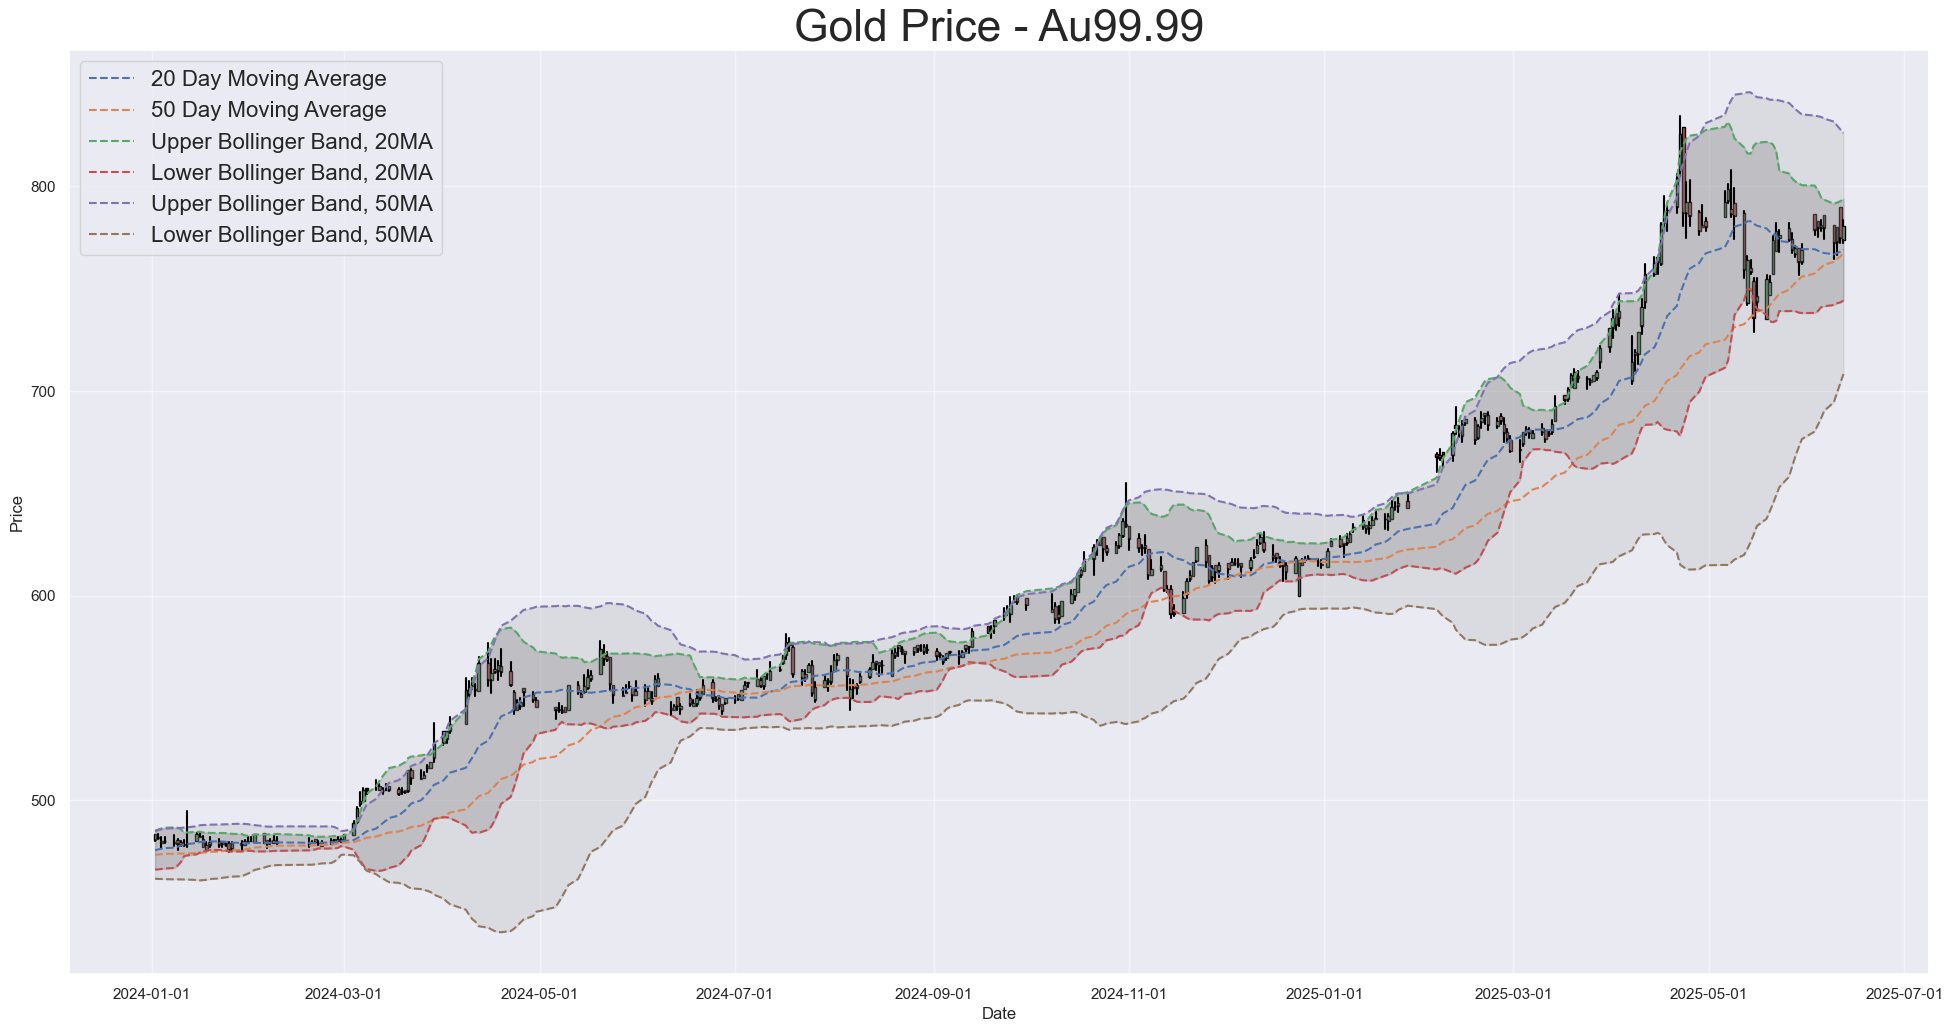

In [7]:
spot_hist_sge_df['20 Day MA'] = spot_hist_sge_df['close'].rolling(window=20).mean()
spot_hist_sge_df['20 Day STD'] = spot_hist_sge_df['close'].rolling(window=20).std()
spot_hist_sge_df['50 Day MA'] = spot_hist_sge_df['close'].rolling(window=50).mean()
spot_hist_sge_df['50 Day STD'] = spot_hist_sge_df['close'].rolling(window=50).std()        
# Calculate upper and lower bands
spot_hist_sge_df['Upper Band - 20MA'] = spot_hist_sge_df['20 Day MA'] + (spot_hist_sge_df['20 Day STD'] * 2)
spot_hist_sge_df['Lower Band - 20MA'] = spot_hist_sge_df['20 Day MA'] - (spot_hist_sge_df['20 Day STD'] * 2)
spot_hist_sge_df['Upper Band - 50MA'] = spot_hist_sge_df['50 Day MA'] + (spot_hist_sge_df['50 Day STD'] * 2.5)
spot_hist_sge_df['Lower Band - 50MA'] = spot_hist_sge_df['50 Day MA'] - (spot_hist_sge_df['50 Day STD'] * 2.5)
spot_hist_sge_df['120 Day MA'] = spot_hist_sge_df['close'].rolling(window=120).mean()
spot_hist_sge_df['200 Day MA'] = spot_hist_sge_df['close'].rolling(window=200).mean()

df = spot_hist_sge_df[spot_hist_sge_df['date']>='2024-01-01']

ax = plot_candlestick(df, figsize=(24,12))
ax.grid(True, alpha=0.5)
ax.plot(df['date'], df['20 Day MA'], ls='--', label='20 Day Moving Average')
ax.plot(df['date'], df['50 Day MA'], ls='--', label='50 Day Moving Average')

ax.plot(df['date'], df['Upper Band - 20MA'], ls='--', label='Upper Bollinger Band, 20MA')
ax.plot(df['date'], df['Lower Band - 20MA'], ls='--', label='Lower Bollinger Band, 20MA')
ax.fill_between(df['date'], df['Upper Band - 20MA'], df['Lower Band - 20MA'], color='gray', alpha=0.3) # Fill the area between the bands
ax.plot(df['date'], df['Upper Band - 50MA'], ls='--', label='Upper Bollinger Band, 50MA')
ax.plot(df['date'], df['Lower Band - 50MA'], ls='--', label='Lower Bollinger Band, 50MA')
ax.fill_between(df['date'], df['Upper Band - 50MA'], df['Lower Band - 50MA'], color='gray', alpha=0.15) # Fill the area between the bands

ax.set_title('Gold Price - Au99.99', fontsize=32)
ax.legend(fontsize=16)

[[478.71780488]
 [508.5265    ]
 [549.12043478]
 [566.51772727]
 [596.59733333]
 [621.39754386]
 [675.78607143]
 [703.73846154]
 [733.40909091]
 [772.60371429]] [[482.11525   ]
 [509.145     ]
 [553.73380952]
 [572.54254545]
 [610.69565217]
 [632.59205128]
 [682.72555556]
 [712.38866667]
 [757.9925    ]
 [792.05413793]]


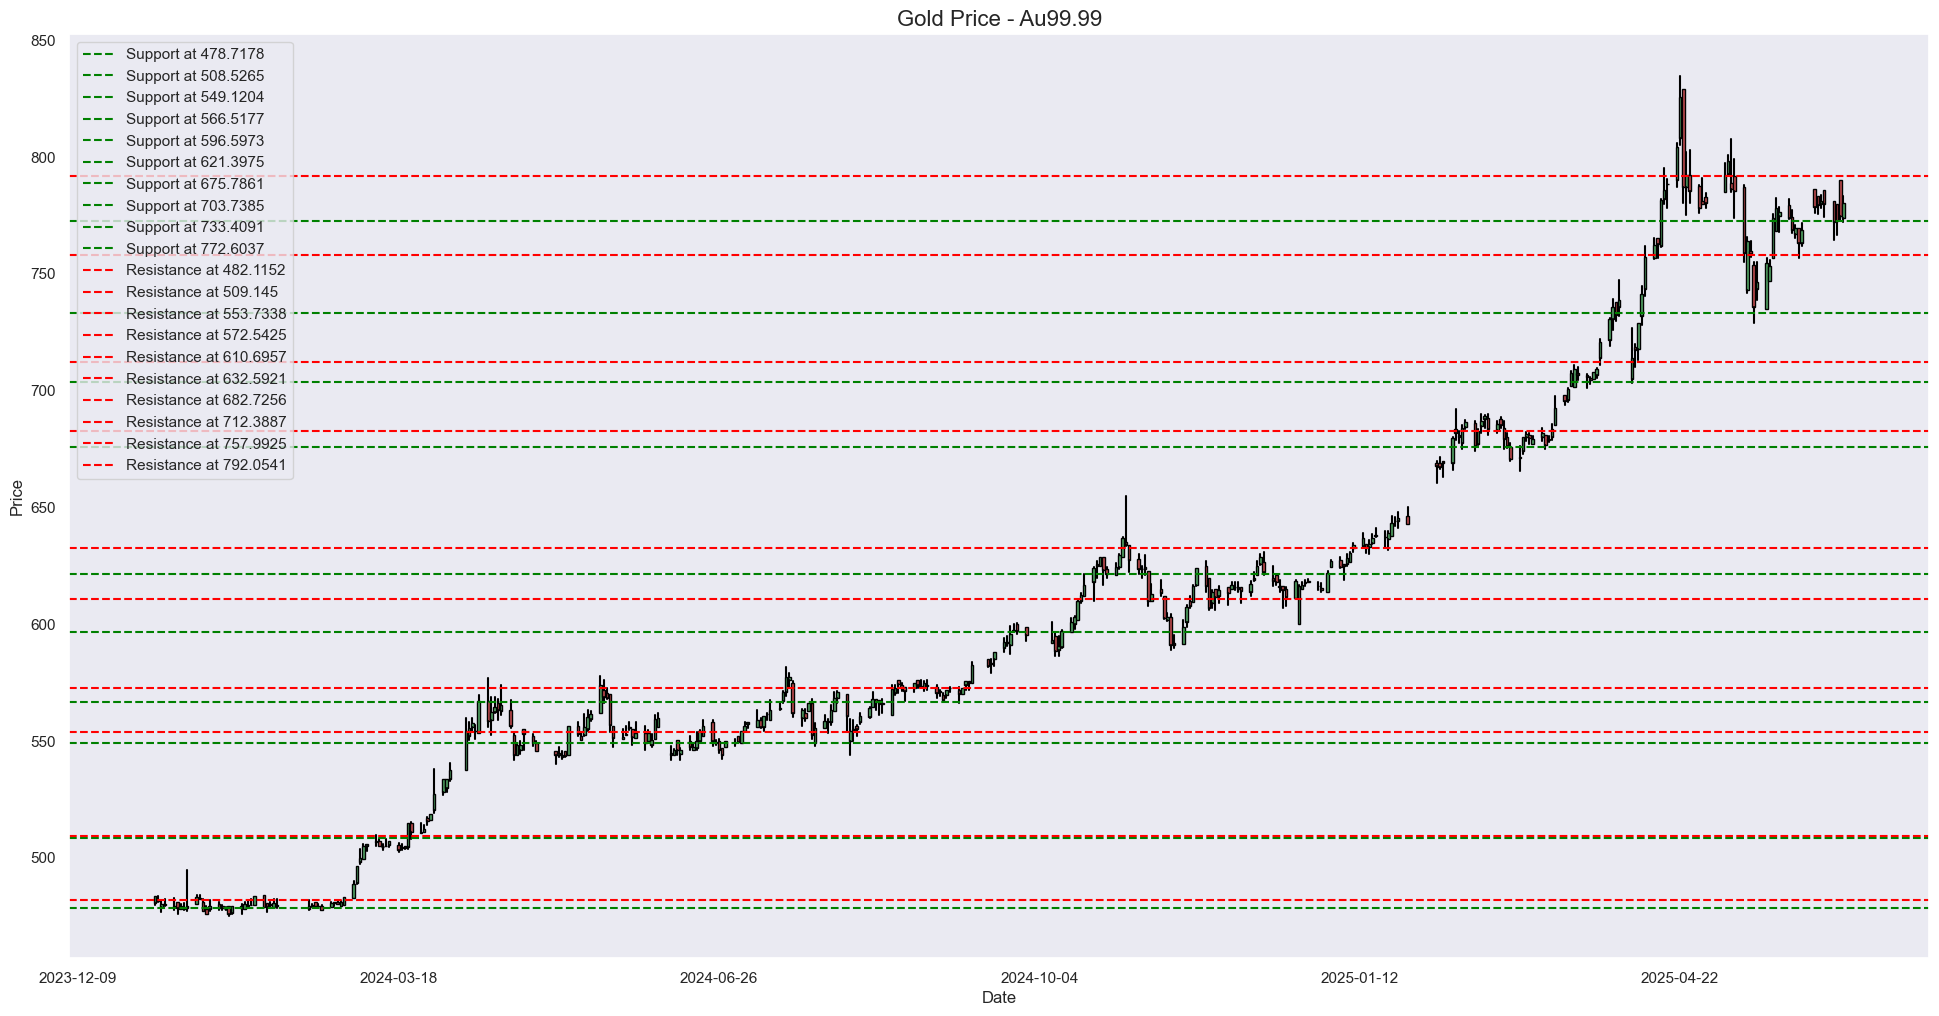

In [8]:
df_plot = spot_hist_sge_df[spot_hist_sge_df['date'].between('2024-01-01',datetime.today().strftime('%Y-%m-%d'))]
ax = plot_candlestick(df_plot, figsize=(24,12))
low_centers, high_centers = support_and_resistance(df_plot)
print(low_centers, high_centers)
for low in low_centers[:]:
    ax.axhline(low[0], color='green', ls='--', label=f'Support at {round(low[0],4)}')
for high in high_centers[:]:
    ax.axhline(high[0], color='red', ls='--', label=f'Resistance at {round(high[0],4)}')
ax.set_title("Gold Price - Au99.99", fontsize=16)
ax.legend(loc='upper left')

In [9]:
last_49day_price = spot_hist_sge_df['close'][-50:-1]
p_ma = np.mean(last_49day_price)
print('50MA break point:', round(p_ma,2))

50MA break point: 766.91


In [10]:
# Huangjin, realtime
spot_quotations_sge_df = ak.spot_quotations_sge(symbol="Au99.99")
spot_quotations_sge_df[spot_quotations_sge_df['时间'] == spot_quotations_sge_df['时间'].max()]

,品种,时间,现价,更新时间
239,Au99.99,23:59,785.0,2025年06月13日 13:08:55


In [11]:
spot_quotations_sge_df[spot_quotations_sge_df['时间'] == spot_quotations_sge_df['时间'].max()]['现价']

239    785.0
Name: 现价, dtype: float64

## Try using etf_strategy and commodity_strategy

* Current etf price: 1.32 ~ up 1.37 , down 1.31
* Recent high: 1.53
* Current etf price is at 86.57000000000001% of recent high
Latest 20 Day MA: 1.26
Latest lower Bollinger Band, 20MA: 1.17
Latest higher Bollinger Band, 20MA: 1.34
Latest 50 Day MA: 1.21
Latest lower Bollinger Band, 50MA: 1.04
Latest higher Bollinger Band, 50MA: 1.38
Latest 50 Day EMA: 1.25
Latest 120 Day MA: 1.3
Latest 200 Day MA: 1.27
Latest 200 Day EMA: 1.25

Latest RSI: 69.58 
Latest MACD Divergence: 0.01 
50MA crosses 200MA at 4.1
20MA break point: 1.26
20MA lower Bollinger Band break point: 1.16
20MA Upper Bollinger Band break point: 1.35
50MA break point: 1.21
50MA lower Bollinger Band break point: 1.02
50MA Upper Bollinger Band break point: 1.39
120MA break point: 1.3
200MA break point: 1.28
[[0.90713636]
 [1.01381111]
 [1.09808333]
 [1.16086842]
 [1.23714545]
 [1.31054386]
 [1.38806   ]]
[[0.93563158]
 [1.01504082]
 [1.06487037]
 [1.12613889]
 [1.17892647]
 [1.23718182]
 [1.30573913]
 [1.36848   ]
 [1.442     

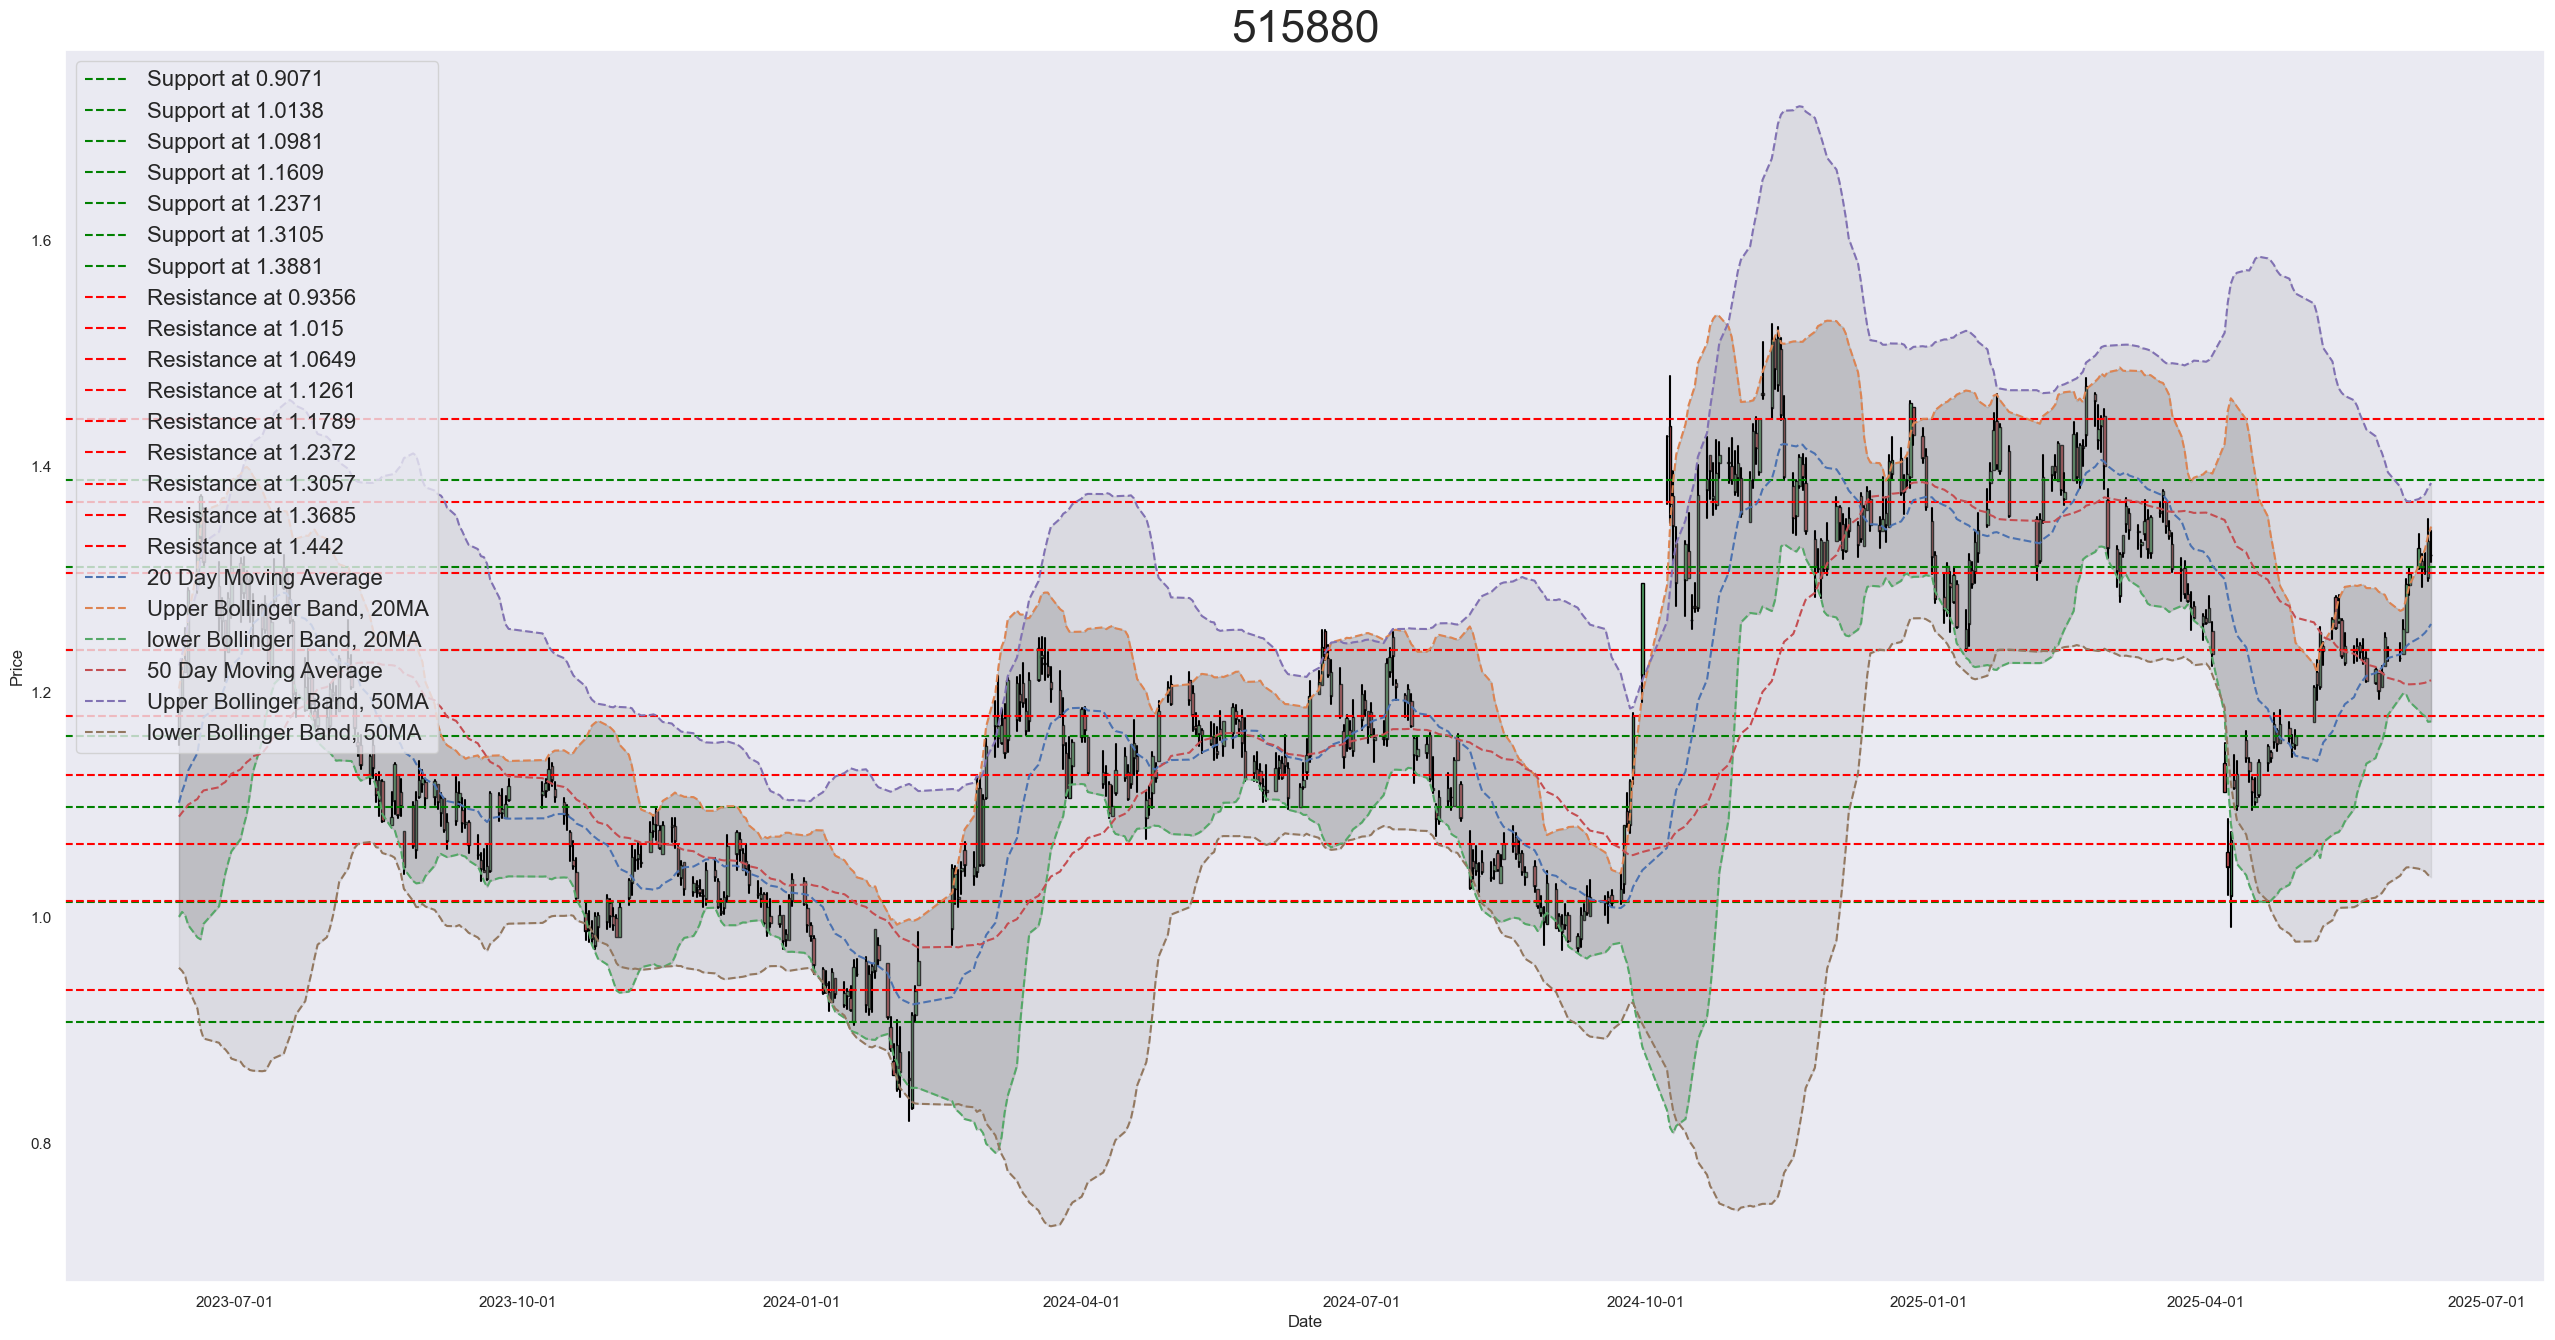

In [12]:
etf_code = "515880"
etf_strategy(etf_code, strategy='daily').output()

* Current etf price: 1.32
* Recent high: 1.53
* Current etf price is at 86.57000000000001% of recent high
Latest 20 Day MA: 1.26
Latest lower Bollinger Band, 20MA: 1.17
Latest higher Bollinger Band, 20MA: 1.34
Latest 50 Day MA: 1.21
Latest lower Bollinger Band, 50MA: 1.04
Latest higher Bollinger Band, 50MA: 1.38
Latest 50 Day EMA: 1.25
Latest 120 Day MA: 1.3
Latest 200 Day MA: 1.27
Latest 200 Day EMA: 1.25

Latest RSI: 69.58 
Latest MACD Divergence: 0.01 
50MA crosses 200MA at 4.1
20MA break point: 1.26
20MA lower Bollinger Band break point: 1.16
20MA Upper Bollinger Band break point: 1.35
50MA break point: 1.21
50MA lower Bollinger Band break point: 1.02
50MA Upper Bollinger Band break point: 1.39
120MA break point: 1.3
200MA break point: 1.28


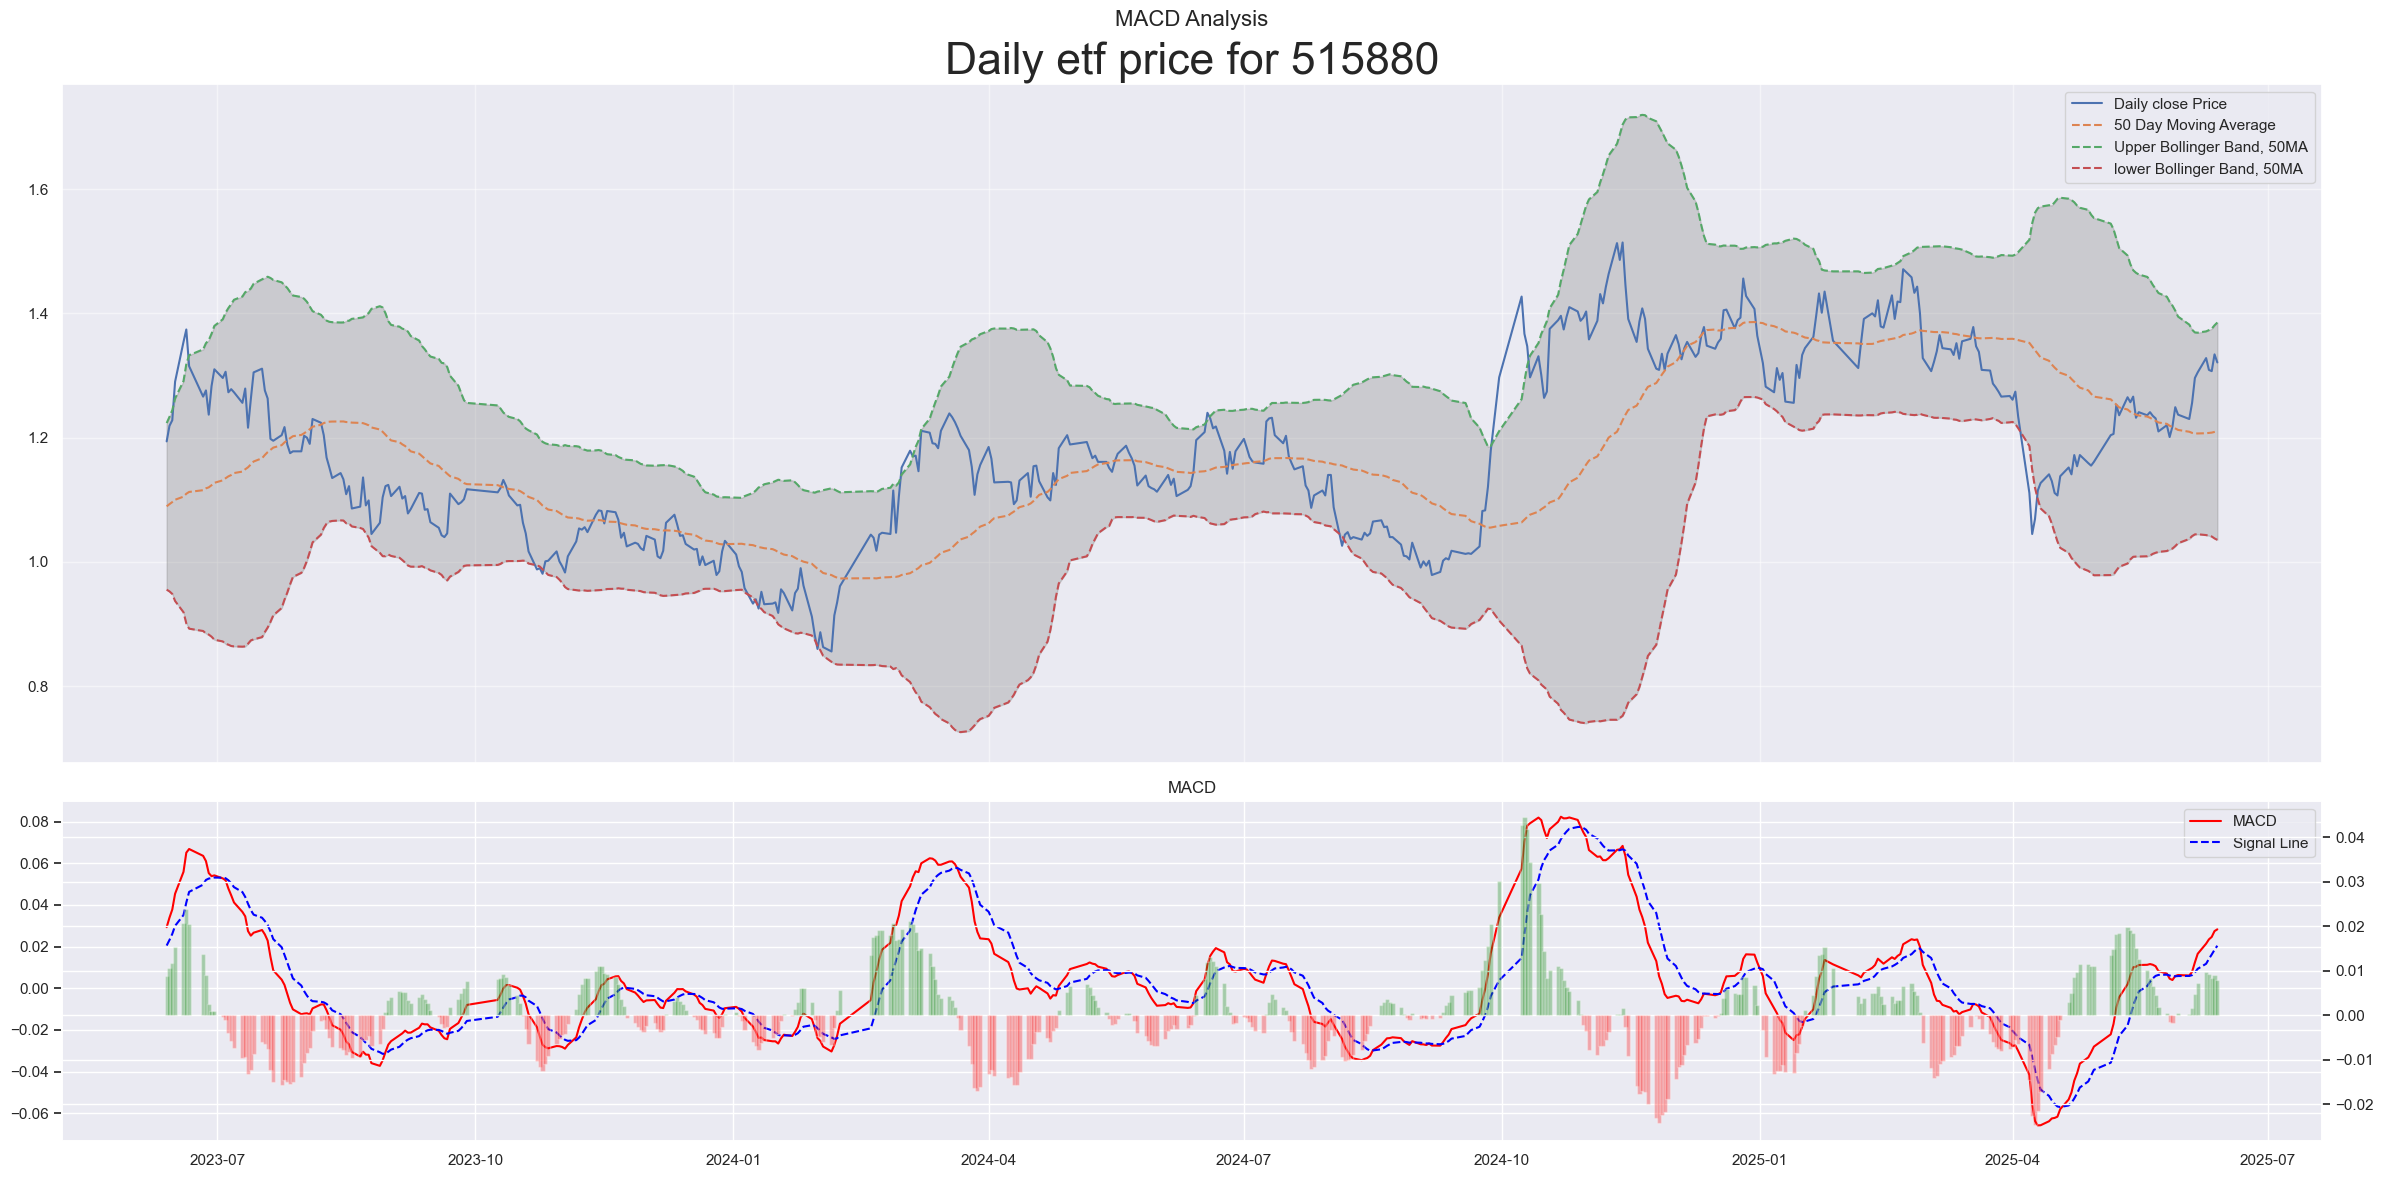

In [13]:
etf_strategy(etf_code).output()

Break all support; record min commodity price
Break all resistance; record max commodity price
* Current commodity price: 239    785.0
Name: 现价, dtype: float64 ~ up 834.6 , down 435.5
* Recent high: 834.6
* Current commodity price is at 239    94.06
Name: 现价, dtype: float64% of recent high
Latest 20 Day MA: 769.12
Latest lower Bollinger Band, 20MA: 744.22
Latest higher Bollinger Band, 20MA: 794.01
Latest 50 Day MA: 767.19
Latest lower Bollinger Band, 50MA: 708.33
Latest higher Bollinger Band, 50MA: 826.04
Latest 50 Day EMA: 758.17
Latest 120 Day MA: 703.7
Latest 200 Day MA: 661.4
Latest 200 Day EMA: 675.58

Latest RSI: 52.07 
Latest MACD Divergence: 0.0 
20MA break point: 0.0
20MA lower Bollinger Band break point: 0.0
20MA Upper Bollinger Band break point: 0.0
50MA break point: 0.0
50MA lower Bollinger Band break point: 0.0
50MA Upper Bollinger Band break point: 0.0
120MA break point: 0.0
200MA break point: 0.0
[[453.45629032]
 [472.73782051]
 [504.468     ]
 [548.21625   ]
 [567.66025

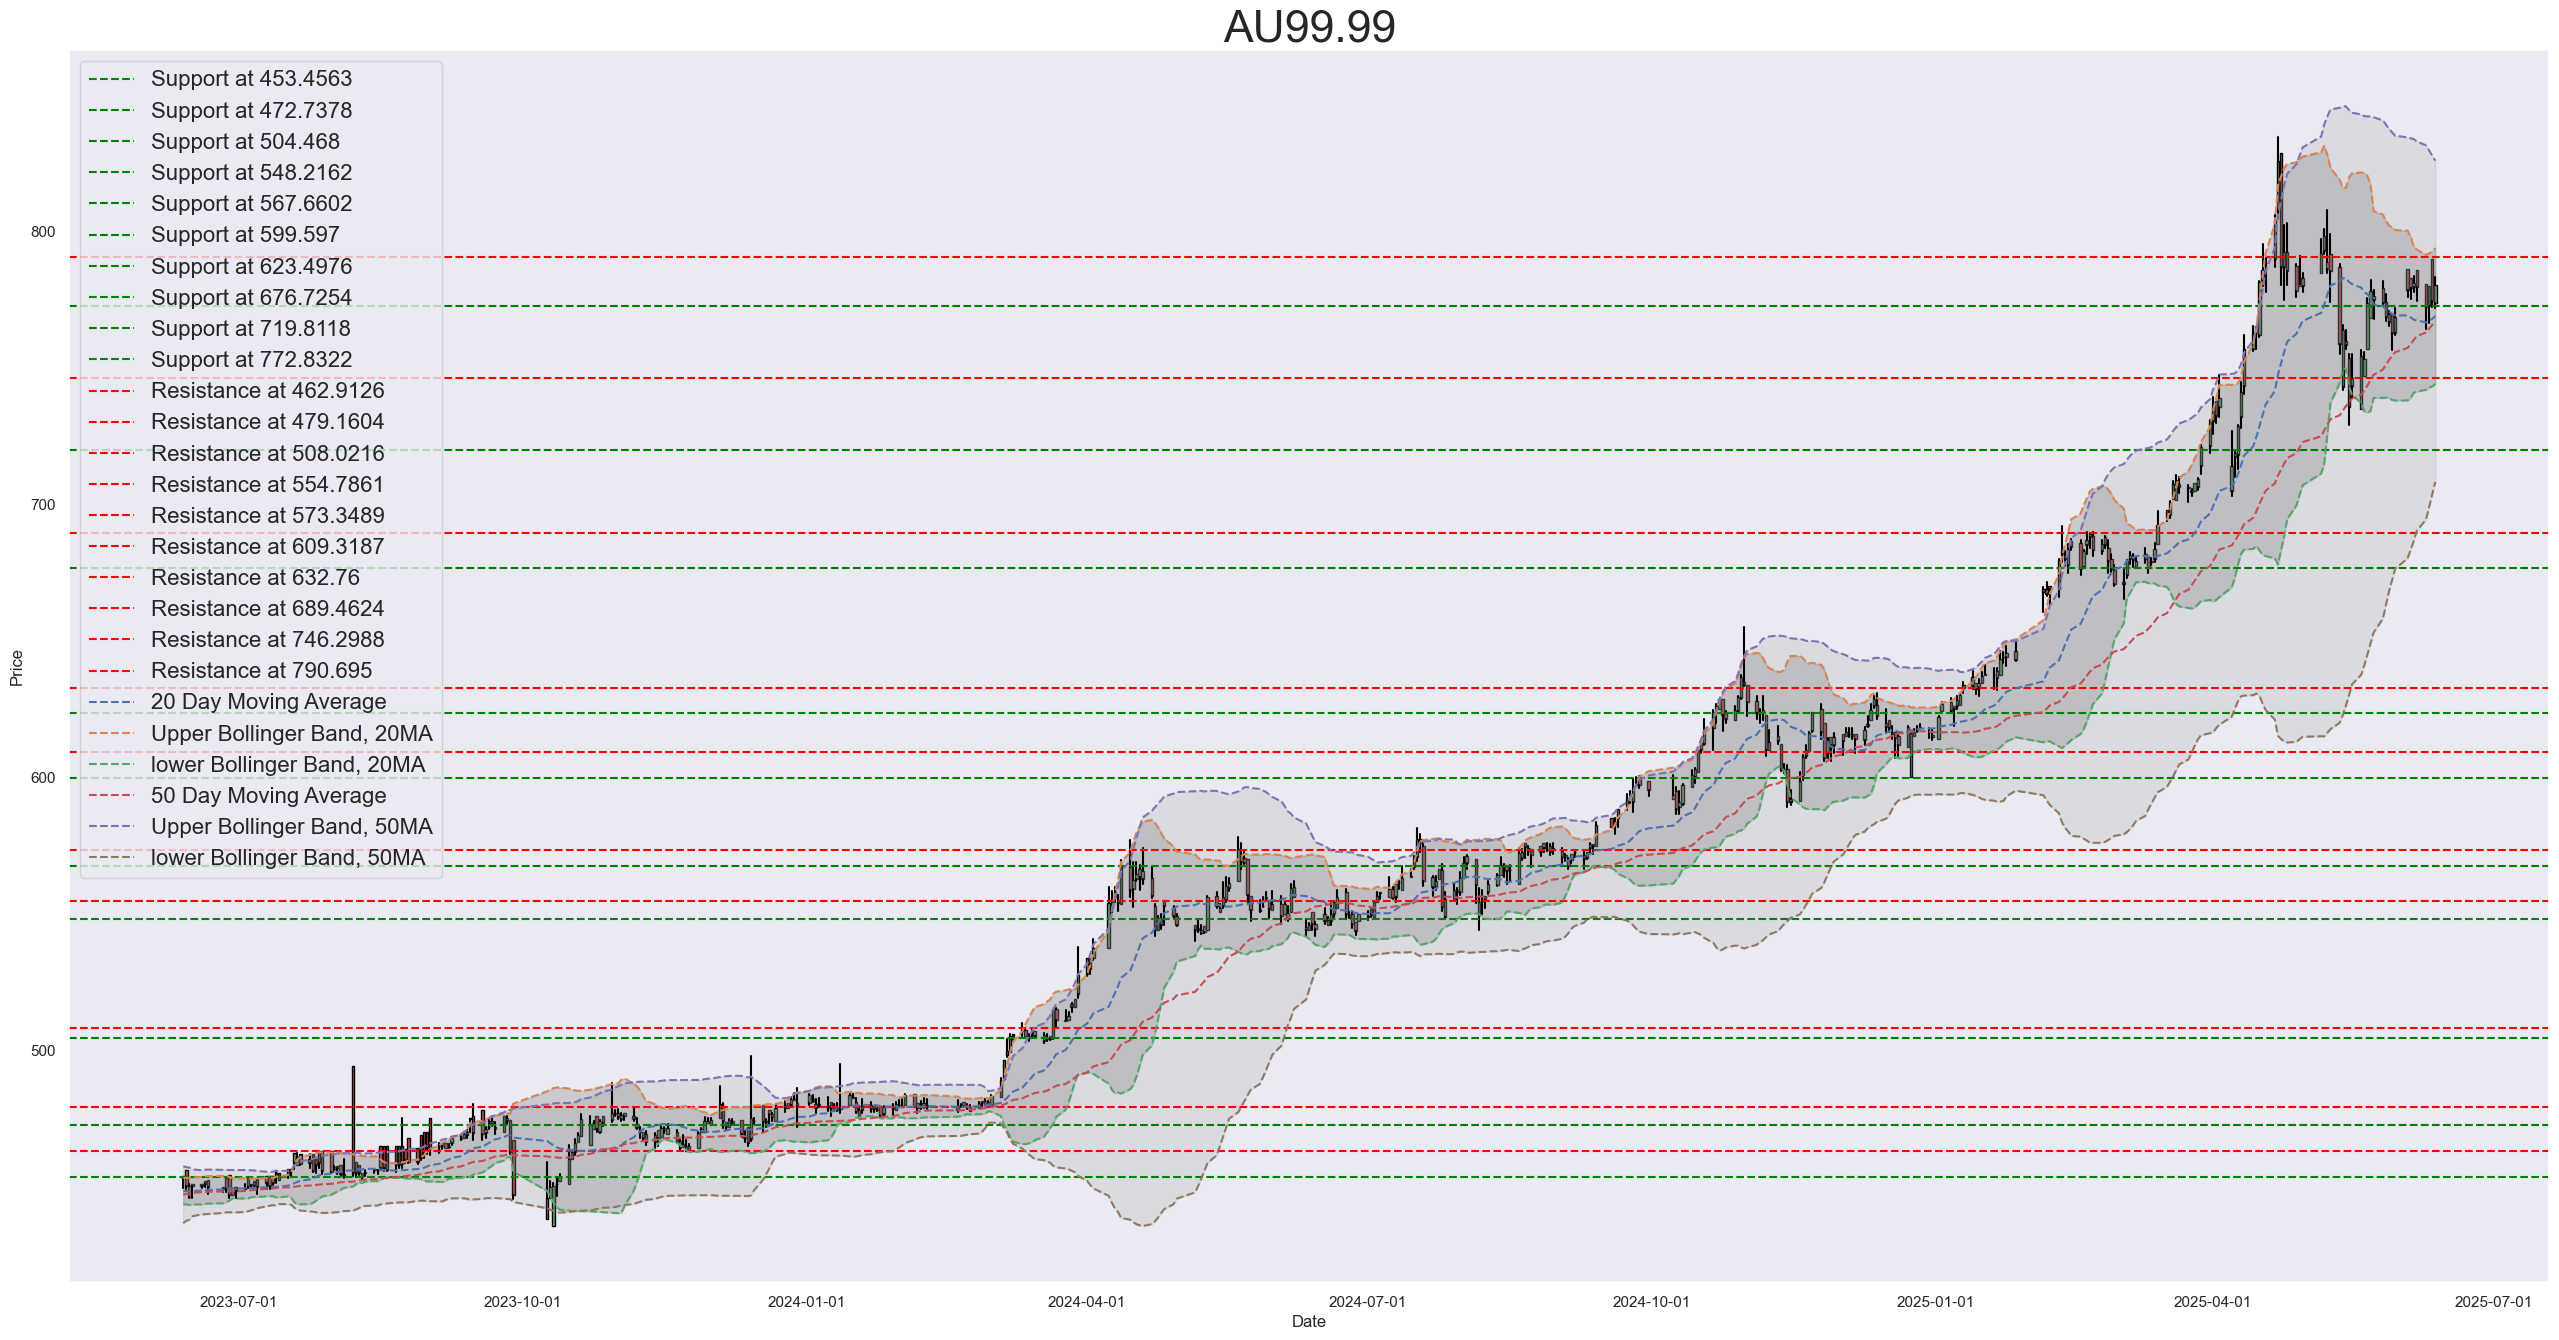

In [14]:
commodity_code = 'Au99.99'
commodity_strategy(commodity_code, strategy='daily').output()

* Current commodity price: 239    785.0
Name: 现价, dtype: float64
* Recent high: 834.6
* Current commodity price is at 239    94.06
Name: 现价, dtype: float64% of recent high
Latest 20 Day MA: 769.12
Latest lower Bollinger Band, 20MA: 744.22
Latest higher Bollinger Band, 20MA: 794.01
Latest 50 Day MA: 767.19
Latest lower Bollinger Band, 50MA: 708.33
Latest higher Bollinger Band, 50MA: 826.04
Latest 50 Day EMA: 758.17
Latest 120 Day MA: 703.7
Latest 200 Day MA: 661.4
Latest 200 Day EMA: 675.58

Latest RSI: 52.07 
Latest MACD Divergence: 0.0 
20MA break point: 0.0
20MA lower Bollinger Band break point: 0.0
20MA Upper Bollinger Band break point: 0.0
50MA break point: 0.0
50MA lower Bollinger Band break point: 0.0
50MA Upper Bollinger Band break point: 0.0
120MA break point: 0.0
200MA break point: 0.0


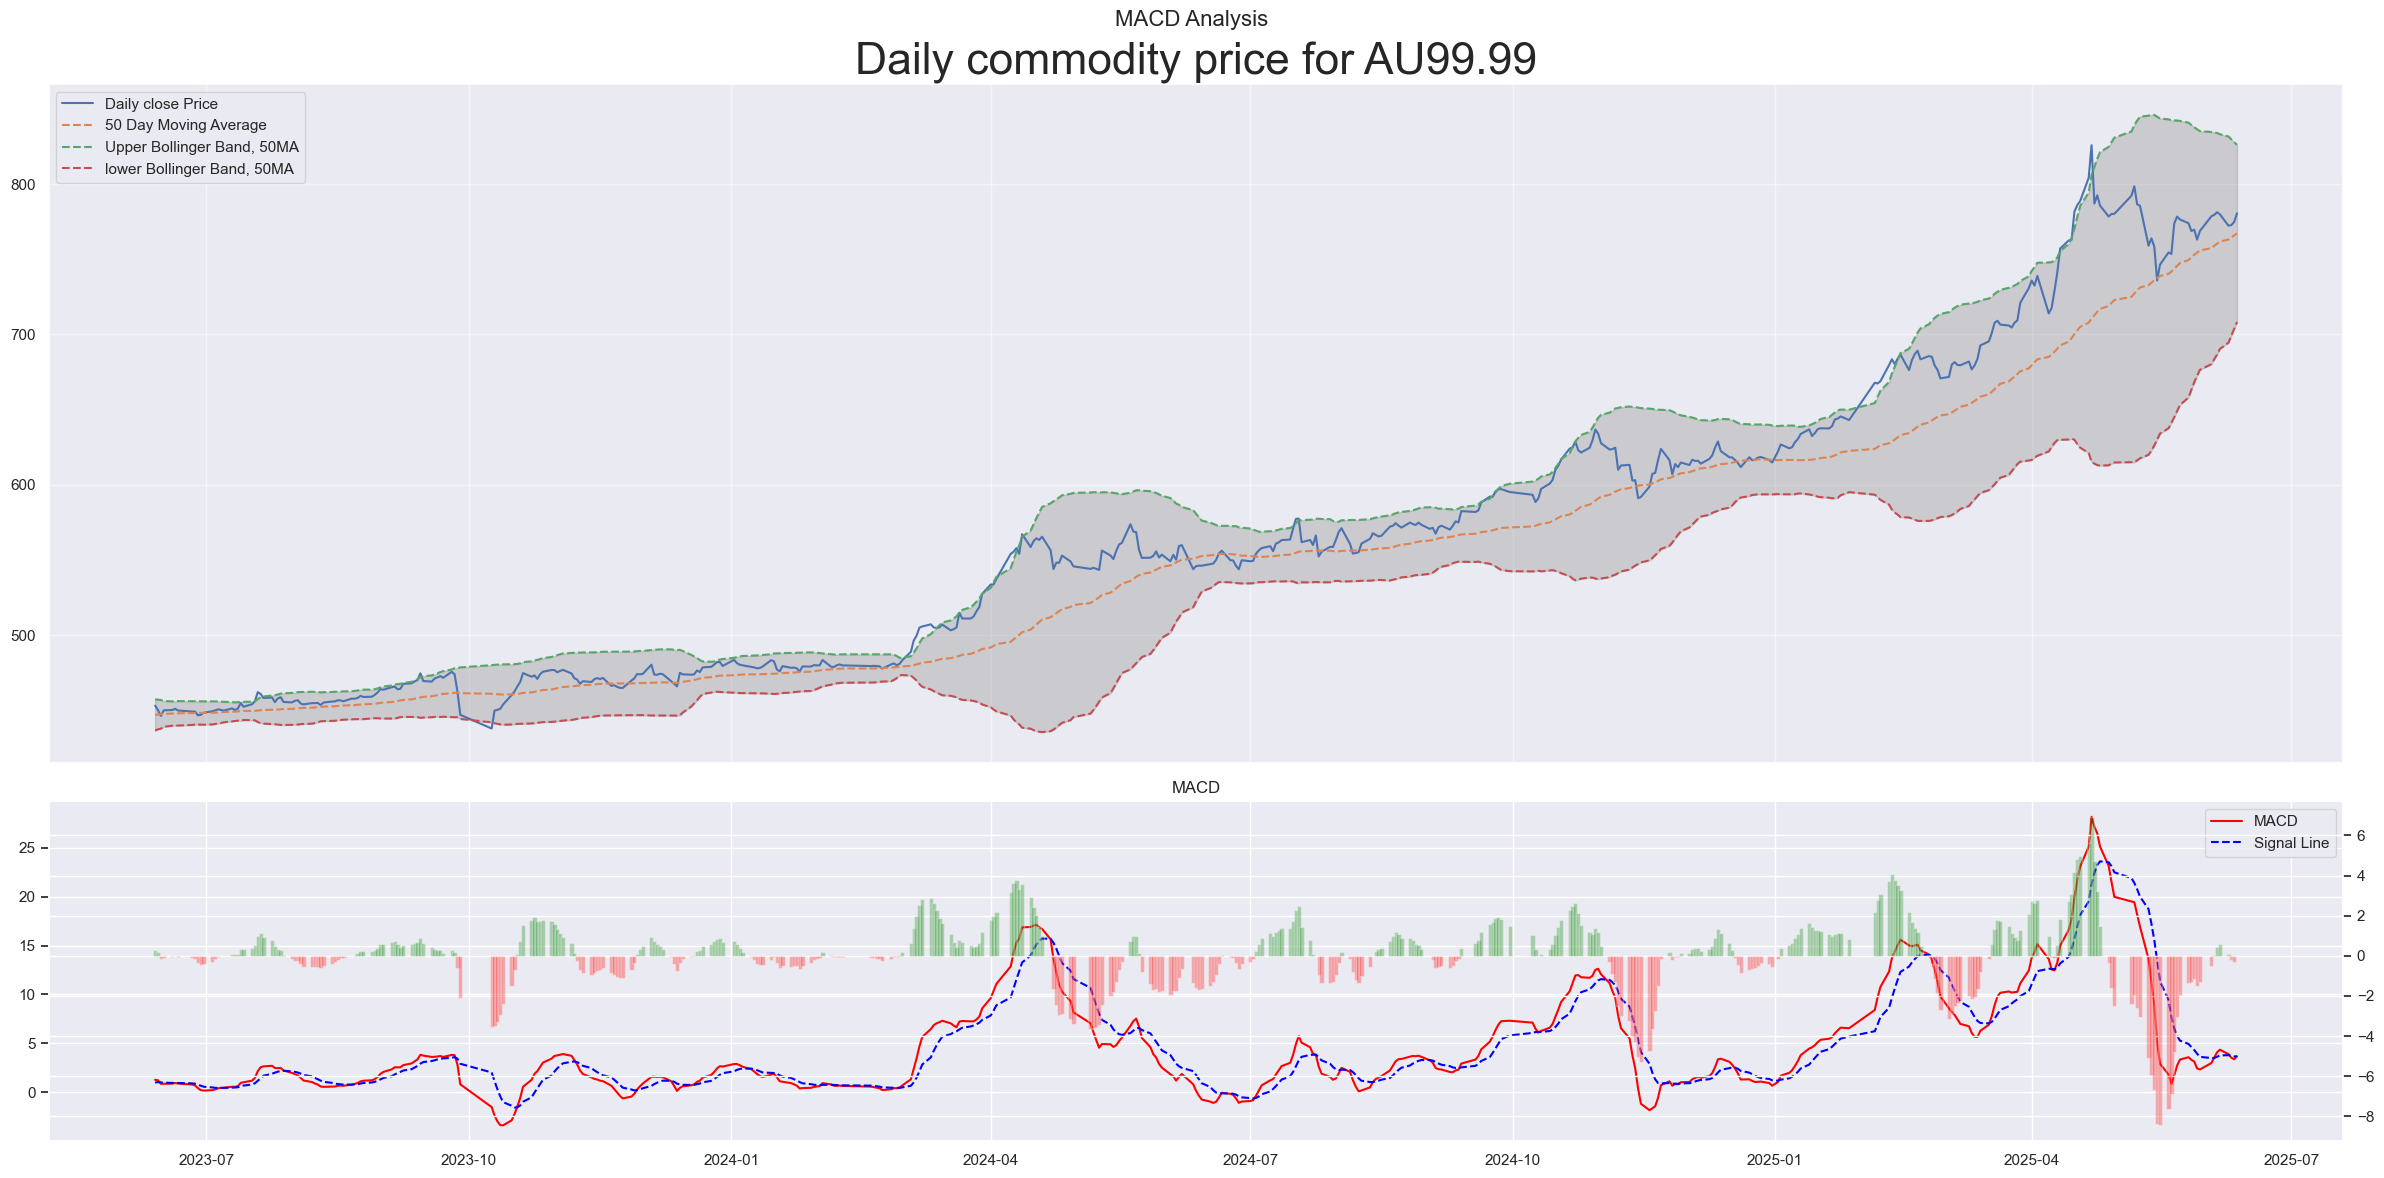

In [15]:
commodity_code = 'Au99.99'
commodity_strategy(commodity_code).output()